# Overview
This notebook provides the ability to generate random droplet parameters, write them to disk, and 
train a neural network with said droplet parameters to approximate the underlying ODEs that govern 
the droplet parameters.  Once trained researchers can generate a Fortran 90 module that provides 
the ability to estimate droplet radius and temperature for some time in the future.  

The intent is that a small, reasonably trained neural network can provide accurate enough droplet 
characteristic estimations that are significantly faster than an iterative Gauss-Newton technique.
Initial testing indicates a small 4-layer network (roughly 2400 parameters) with Fortran 90 module
generated by this notebook is 30-90x faster than the existing (as of 2024/09/25) iterative approach 
which results in roughly a factor of 2x overall simulation speedup.

This notebook is broken down into the following sections:

1. ODEs of interest
2. Mapping data to/from $[-1, 1]$
3. Generating random droplets
4. Training a neural network
5. Analyzing a network's performance
6. Exporting a network to Fortran 90



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


from droplet_approximation.physics import scale_droplet_parameters
from droplet_approximation.analysis import  analyze_model_iterative_performance, mse_score_models
from droplet_approximation.models import *
from droplet_approximation.models import do_iterative_inference, generate_fortran_module




In [2]:
model_load_paths = ["../models/network_NTLP_decoupled.pth",
                    "../models/network_NTLP_decoupled_400M.pth",
                    "../models/network_NTLP_decoupled_weighted.pth"]

testing_data_file = "../data/uncoupled_eval_data_stripped.data"


In [3]:
model_count = len(model_load_paths)

model_names = [path.split( "/" )[-1].split( "." )[0] for path in model_load_paths]

models = [SimpleNet() for i in range(model_count)]

for i in range(model_count):
    models[i].load_state_dict( torch.load(model_load_paths[i]))

Inputs: [8.4861786e-06 3.0473376e+02 2.2302863e-18 2.9453928e+02 9.5196050e-01
 1.0015783e+00]
Inputs: [8.4861786e-06 3.0473376e+02 2.2302863e-18 2.9453928e+02 9.5196050e-01
 1.0015783e+00]
Inputs: [8.4861786e-06 3.0473376e+02 2.2302863e-18 2.9453928e+02 9.5196050e-01
 1.0015783e+00]


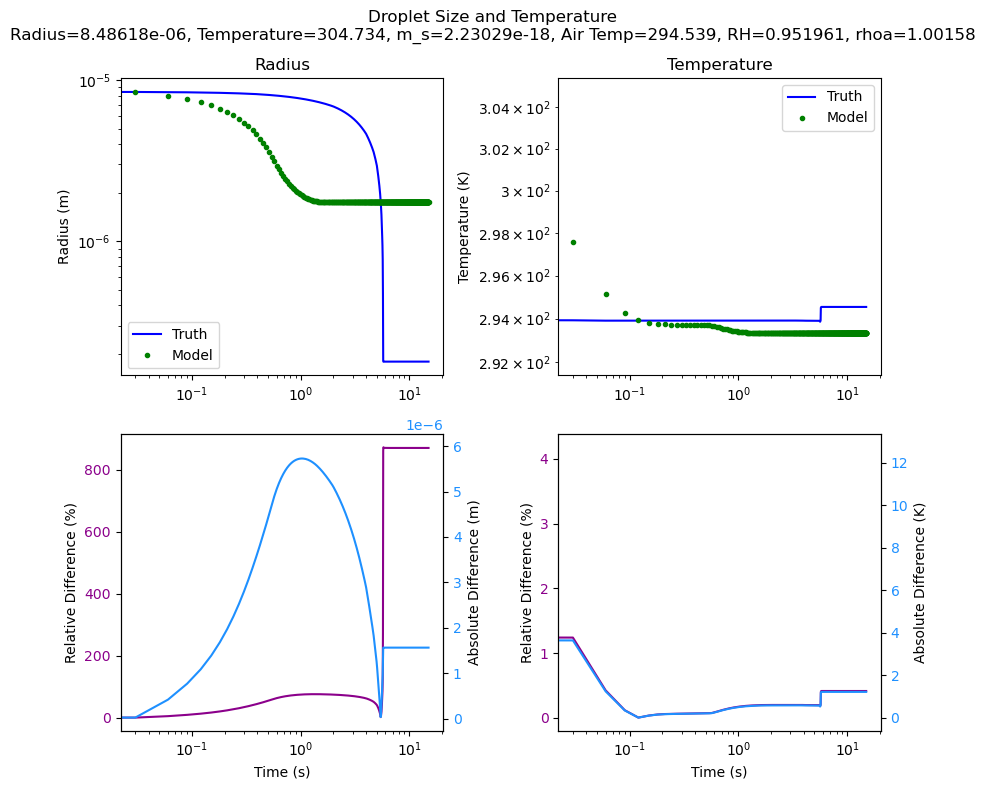

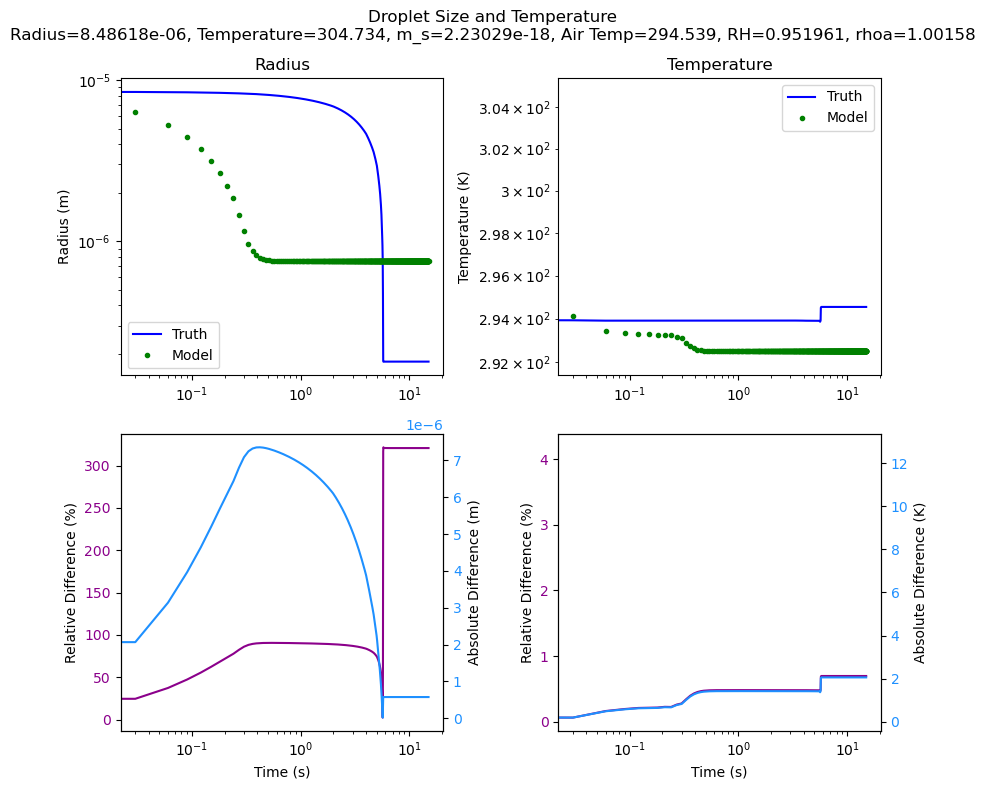

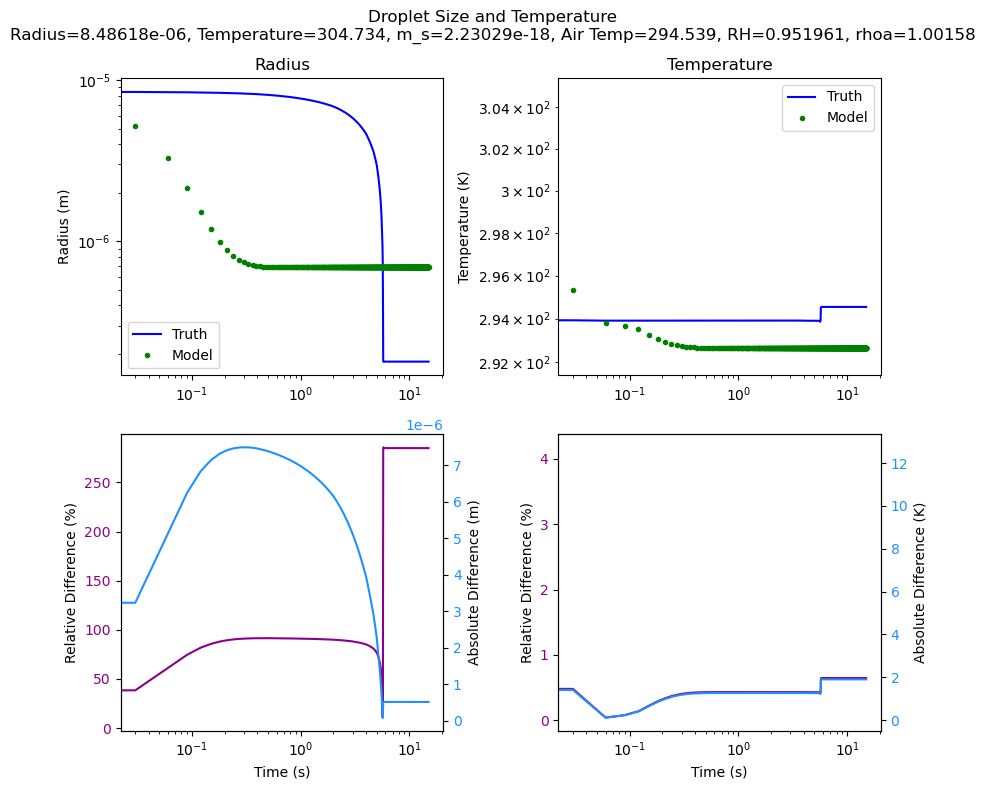

In [7]:

graph_count = 1
dt = 0.03
final_time = 15.0

for i in range(graph_count):
    input_parameters = scale_droplet_parameters(np.array( np.random.uniform( low = -1.0, high = 1.0, size=(1,6)).astype( "float32" )))[0]
    for j in range(model_count):
        analyze_model_iterative_performance(models[j], input_parameters, dt, final_time=final_time)

In [8]:
losses = mse_score_models(models,testing_data_file, "cpu")
rankings = np.argsort(losses)

print("Models sorted best to worst:\n")
for i in range(model_count):
    print("Loss for " + model_names[rankings[i]] + ": ", losses[rankings[i]])

Models sorted best to worst:

Loss for network_NTLP_decoupled_400M:  0.00031405674991227437
Loss for network_NTLP_decoupled_weighted:  0.0003320732664702321
Loss for network_NTLP_decoupled:  0.00038489603105809937


In [10]:

losses = mse_score_models(models,testing_data_file, "cpu",weighted= True, normalized=False)
rankings = np.argsort(losses)

print("Models sorted best to worst MSE:\n")
for i in range(model_count):
    print("Loss for " + model_names[rankings[i]] + ": ", losses[rankings[i]])

Models sorted best to worst MSE:

Loss for network_NTLP_decoupled_weighted:  0.0003617535666031139
Loss for network_NTLP_decoupled:  0.0005106924711558039


In [4]:
losses = mse_score_models(models,testing_data_file, "cpu", normalized=True )
rankings = np.argsort(losses)

print("Models sorted best to worst:\n")
for i in range(model_count):
    print("Loss for " + model_names[rankings[i]] + ": ", losses[rankings[i]])

Models sorted best to worst:

Loss for network_NTLP_decoupled_weighted:  2.1131655446859945e-06
Loss for network_NTLP_decoupled:  2.8828772231468806e-06


In [5]:
losses = mse_score_models(models,testing_data_file, "cpu", weighted=True, normalized=True )
rankings = np.argsort(losses)

print("Models sorted best to worst:\n")
for i in range(model_count):
    print("Loss for " + model_names[rankings[i]] + ": ", losses[rankings[i]])

Models sorted best to worst:

Loss for network_NTLP_decoupled_weighted:  2.5599740775393405e-06
Loss for network_NTLP_decoupled:  5.557157232120389e-06


In [15]:
generate_fortran_module(model_names[rankings[0]], models[rankings[0]].state_dict(), "../models/droplet_model.f90")